# <span style="color:#ff00aa">Procesamiento de los datos</span>

In [1]:
# Importaciones
import funciones as f
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Cargamos el DataFrame
data = pd.read_csv('properties_colombia/properties_colombia_train.csv')

In [3]:
# Vemos nulos por columna
f.valoresFaltantes(data)

e:\HENRY\DataScience\LABS\PI02-DATATHON\funciones.py:25: FutureWarning: In a future version of pandas all arguments of Series.sort_values will be keyword-only.
  nulos = nulos.sort_values(nulos[1], ascending=False)


l6                 96.523900
surface_total      96.469737
surface_covered    95.038193
l5                 86.125468
rooms              86.060674
price_period       81.791353
bedrooms           79.486102
l4                 77.035065
lat                25.056062
lon                25.056062
bathrooms          20.795853
l3                  5.584437
description         0.061251
currency            0.033916
price               0.031891
title               0.000506
operation_type      0.000000
property_type       0.000000
Unnamed: 0          0.000000
id                  0.000000
l2                  0.000000
l1                  0.000000
created_on          0.000000
end_date            0.000000
start_date          0.000000
ad_type             0.000000
geometry            0.000000
dtype: float64

[]

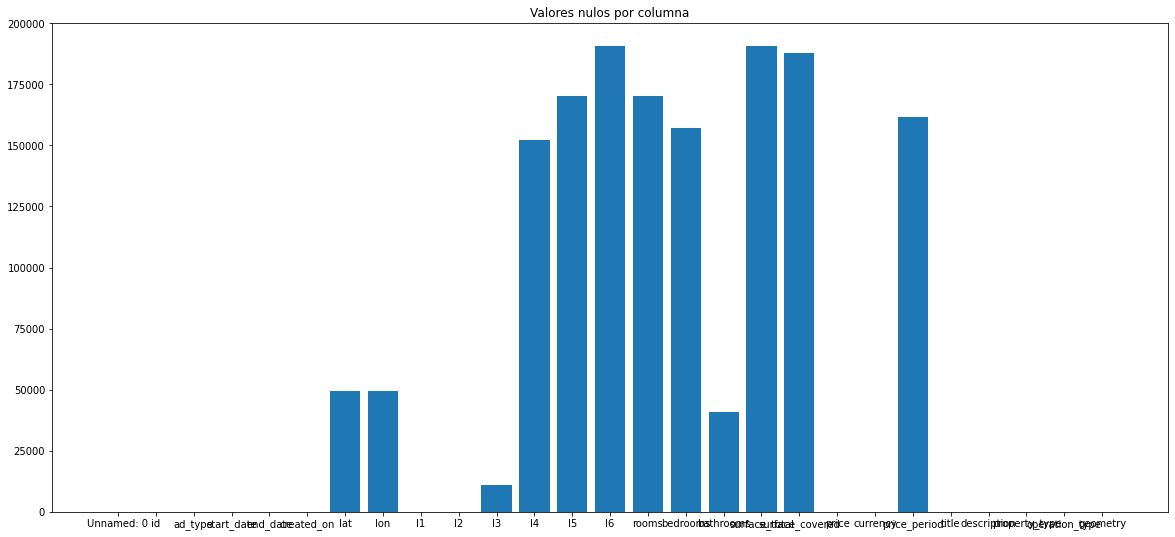

In [5]:
cols = data.columns
nulos = data.isnull().sum()
plt.figure(figsize=(20, 9))
plt.title('Valores nulos por columna')
plt.bar(cols, nulos)
#sns.barplot(x=cols, y=nulos)
plt.plot()

 Dado la cantidad de nulos en características importantes como latitud y longitud, al igual que la superficie cubierta, tomé la descripción para obtener palabras reelevantes que me permitan deducir si una propiedad es cara o no.


In [6]:
# Vemos descripciones faltantes en la columna descripción
data['description'].isnull().sum()

121

Eliminamos las descripciones faltantes en el set de entrenamiento dado que no mejoran la performance del mismo al aplicar la función que desarrollé para crear una descripción en función de los datos con los que cuento de cada propiedad.

In [7]:
# Eliminamos las descripciones vacías porque mejora la performance del modelo
data.dropna(subset='description', inplace=True)

In [8]:
# Revisamos que no hayan quedado registros con descripciones vacías
data['description'].isnull().sum()

0

In [9]:
data.price.isnull().sum()

63

Elimino los precios nulos, si bien en el set de test puede llegar a haber precios nulos, desconozco el criterio empleado con dichos valores que se implementó para determinar si una propiedad es cara o no.

In [10]:
# Eliminamos nulos de la columna precio
data.dropna(subset='price', inplace=True)

In [11]:
# Confirmamos la eliminación de precios nulos
data.price.isnull().sum()

0

Al igual que en punto anterior, desconozco el criterio empleado con los precios en 0, por este motivo los elimino del set de entrenamiento

In [12]:
# Vemos cuantos valores de price son 0
data['price'][data.price == 0].count()

4

In [13]:
#data[data.price > 0].shape
data.shape

(197365, 27)

In [14]:
# Nos quedamos con los precios mayores a 0
data = data[data.price > 0]

Nuevamente, al no saber el criterio que se adoptó con las propiedades con valores en USD, las elimino. Lo correcto hubiese sido convertir los precios en USD a moneda colombiana y después determinar si la propiedad es cara o no, pero no se si ese fue el criterio utilizado con el set de test, por lo tanto los elimino dado que mi predicción se basa en las características de la propiedad que obtengo de la descripción de la misma

In [15]:
# Vemos cuantos precios están en dolares
data['currency'][data.currency == 'USD'].count()

8

In [16]:
data = data[data.currency != 'USD']

In [17]:
data.shape

(197353, 27)

In [18]:
# Verificamos que no haya nulos en la columna moneda
data['currency'].isnull().sum()

0

In [19]:
# Nos quedamos con las columnas que nos interesan
data = data[['description', 'price']]

In [20]:
data.shape

(197353, 2)

# <span style="color:#ff00aa">Creación de la columna objetivo</span>

In [21]:
# Obtenemos el promedio de la columna precio
promedio = data['price'].mean()
promedio

643748447.9171433

In [22]:
# Creamos la columna categoría con 0 y 1 en función al precio de la propiedad
# 1 si excede o es igual al promedio del precio y 0 si es inferior
data['category'] = data['price'].apply(lambda x : 1 if x >= promedio else 0)

## <span style="color:#ff00aa">Equilibrio de la columna objetivo</span>

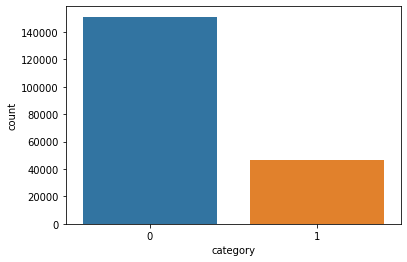

In [23]:
sns.countplot(x='category', data=data)
plt.show()

In [24]:
# Total de registros
total = data.shape[0]
total

197353

In [25]:
# Registros con categoría 1
cat_1 = data[data.category == 1].shape[0]
cat_1

46332

In [26]:
# Registros con categoría 0
cat_0 = data[data.category == 0].shape[0]
cat_0

151021

In [27]:
print(f'Porcentaje de propiedades caras: {round(cat_1 / total * 100, 2)}%')
print(f'Porcentaje de propiedades baratas: {round(cat_0 / total * 100, 2)}%')

Porcentaje de propiedades caras: 23.48%
Porcentaje de propiedades baratas: 76.52%


# <span style="color:#ff00aa">Modelización</span>

In [28]:
# Importaciones
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk

In [29]:
# Obtenemos los stop words de esta biblioteca dado que 
# TF-TDI no tiene los mismos en español
sw = nltk.corpus.stopwords.words('spanish')

In [30]:
# Nos quedamos con la lista de los textos de las descripciones
corpus = data['description']

In [31]:
# Lo convertimos a lista
corpus = list(corpus)

In [32]:
# Cantidad de elementos en la lista que es
# igual a la cantidad de registros obtenidos
len(corpus)

197353

In [33]:
# Instanciamos el vectorizador con los stop words y un máximo de features de 1000
vectorizer = TfidfVectorizer(stop_words=sw, max_features=1000)

In [34]:
# Vectorizamos los datos
x = vectorizer.fit_transform(corpus)

In [35]:
# Vemos la cantidad de datos obtenidos
x.shape

(197353, 1000)

In [36]:
# Obtenemos la variable objetivo
y = data['category']

In [37]:
# Dimension de la variable objetivo
y.shape

(197353,)

In [85]:
# Importaciones
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import recall_score, precision_score, accuracy_score
from sklearn.pipeline import Pipeline
import joblib

# <span style="color:#ff00aa">Creción del Pipeline</span>

In [81]:
pipe_rf = Pipeline([('rf', RandomForestClassifier(n_estimators=50, random_state=0)),])

In [82]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [40]:
#rf = RandomForestClassifier(n_estimators=50, random_state=0)

In [83]:
pipe_rf.fit(x_train, y_train)

Pipeline(steps=[('rf',
                 RandomForestClassifier(n_estimators=50, random_state=0))])

In [86]:
#Guardamos el Pipeline en un archivo Pickle
joblib.dump(pipe_rf, 'modelo_random_forest.pkl', compress=1)

['modelo_random_forest.pkl']

In [87]:
#Cargamos el archivo creado de nuestro modelo
rf = joblib.load('modelo_random_forest.pkl')

In [88]:
#y_pred = rf.predict(x_test)
#Para mejorar el recall ajustamos el umbral (THRESHOLD)
y_pred = np.where(rf.predict_proba(x_test) [:,1] > 0.2, 1, 0)

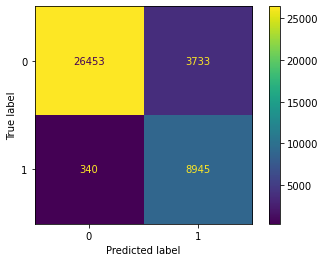

In [89]:
cm = confusion_matrix(y_test, y_pred, labels=rf.classes_)
disp = ConfusionMatrixDisplay(cm, display_labels=rf.classes_)
disp.plot()

In [44]:
rs = recall_score(y_test, y_pred)
ps = precision_score(y_test, y_pred)
ac = accuracy_score(y_test, y_pred)

print(f'Recall: {rs}')
print(f'Precision: {ps}')
print(f'Accuracy: {ac}')

Recall: 0.9633817985998923
Precision: 0.705552926329074
Accuracy: 0.8968103164348509


# <span style="color:#ff00aa">Archivo Test</span>

In [90]:
# Cargamos el DataFrame
data_t = pd.read_csv('properties_colombia/properties_colombia_test.csv')

In [91]:
# Obtenemos los índices de los registros con descripciones vacías
sin_desc = data_t[data_t.description.isnull()].index

In [92]:
def crearDescription(df, num_loc):
    '''
    Arma la descripción faltante con datos existentes

    df: DataFrame a analizar
    num_loc: índice del registro a cambiar
    '''
    cadena = ''
    # Evaluamos con que características contamos para armar
    # las descripciónes faltantes de las propiedades
    if not df.isnull().property_type[num_loc]: 
        if df.property_type[num_loc] != 'Otro':
            cadena += df.property_type[num_loc] + ' '
        else:
            cadena += df.title[num_loc]
    if not df.isnull().l2[num_loc]:
        cadena += df.l2[num_loc] + ' '
    if not df.isnull().l3[num_loc]:
        cadena += df.l3[num_loc] + ' '
    if not df.isnull().l4[num_loc]:
        cadena += df.l4[num_loc] + ' '
    if not df.isnull().bedrooms[num_loc]:
        cadena += str(int(df.bedrooms[num_loc])) + ' habitaciones '
    if not df.isnull().bathrooms[num_loc]:
        cadena += str(int(df.bathrooms[num_loc])) + ' baños' 
    
    return cadena

In [93]:
# Recorremos los índices de los registros con descripciones faltantes
# y las vamos completando
for idx in sin_desc:
    data_t.loc[idx,('description')] = crearDescription(data_t, idx) 
    

In [94]:
# Verificamos que todas las propiedades tengan una descripción
data_t['description'].isnull().sum()

0

In [95]:
# Obtenemos los stop words de esta biblioteca dado que 
# TF-IDF no tiene los mismos en español
sw = nltk.corpus.stopwords.words('spanish')

In [96]:
# Nos quedamos con la lista de los textos de las descripciones
corpus_t = data_t['description']

In [97]:
# Lo convertimos a lista
corpus_t = list(corpus_t)

In [98]:
# Verificamos el tamaño de las descripciones obtendias
# y verificamos que coincide con la cantidad de registros a predecir
len(corpus_t)

65850

In [99]:
# Instanciamos el vectorizador con los stop words y un máximo de features de 1000
vectorizer_t = TfidfVectorizer(stop_words=sw, max_features=1000)

In [100]:
# Vectorizamos los datos
x_t = vectorizer_t.fit_transform(corpus_t)

In [57]:
# Vemos que obtuvimos 1000 caracterísitcas por cada registro
# como lo configuramos al instanciar el vectorizador
x_t.shape

(65850, 1000)

In [101]:
#Para mejorar el recall ajustamos el umbral (THRESHOLD)
y_t_predict = np.where(rf.predict_proba(x_t) [:,1] > 0.2, 1, 0)

### Generación del CSV

In [102]:
# Creamos el DataFrame que contendrá las predicciones obtenidas
datos = pd.DataFrame()

In [103]:
# Creamos la columna pred con los datos obtendiso de la predicción
datos['pred'] = y_t_predict

In [104]:
# Lo guardamos con formato CSV
datos.to_csv('LalaYupii.csv', index=False)